## Imports

In [2]:
%matplotlib inline

import os
import cv2
import math
import imutils
import contextlib2
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from object_detection.dataset_tools import tf_record_creation_util
from object_detection.utils import dataset_util, label_map_util
#from object_detection.dataset_tools.oid_tfrecord_creation import tf_example_from_annotations_data_frame

pd.set_option("display.max_colwidth", 10000)

## Settings and File Paths

In [3]:
SPLIT = "validation" # ["train", "test", "validation"]
LABELS_CSV = "filteredLabels.csv"
LABEL_MAP_PATH = "labelMap.pbtxt"

NUM_SHARDS = 100
RECORDS_FILEPATH = f"{SPLIT}/{SPLIT}.tfrecord"

ANNO_CSV = ""
URLS_CSV = ""

## Load .csv's from urls (optional)

If "ANNO_CSV" or "URLS_CSV" are empty, will load the appropriate csv from:
https://appen.com/datasets/open-images-annotated-with-bounding-boxes/

In [4]:
train_annotations_csv = "https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv"
train_imgs_url_csv = "https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-images-boxable.csv"

val_annotations_csv = "https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv"
val_imgs_url_csv = "https://datasets.figure-eight.com/figure_eight_datasets/open-images/validation-images.csv"

test_annotations_csv = "https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv"
test_imgs_url_csv = "https://datasets.appen.com/appen_datasets/open-images/test-images.csv"

if not ANNO_CSV:
    if SPLIT == "train":
        ANNO_CSV = train_annotations_csv
    elif SPLIT == "test":
        ANNO_CSV = test_annotations_csv
    else:
        ANNO_CSV = val_annotations_csv
        
if not URLS_CSV:
    if SPLIT == "train":
        URLS_CSV = train_imgs_url_csv
    elif SPLIT == "test":
        URLS_CSV = test_imgs_url_csv
    else:
        URLS_CSV = val_imgs_url_csv

# Helper Functions

In [5]:
def get_filtered_bboxes(annotations_path, imgs_path, labels_df):
    anno_df = pd.read_csv(annotations_path)
    url_df = pd.read_csv(imgs_path)
    url_df["ImageID"] = url_df.image_name.apply(lambda x: x.split('.')[0])
    url_df.drop('image_name', axis=1, inplace=True)

    filtered_bboxes = anno_df[(anno_df.IsDepiction == 0) &
                                 anno_df.LabelName.isin(labels_df.LabelName)]

    filtered_bboxes = pd.merge(filtered_bboxes, labels_df, on="LabelName")
    
    return filtered_bboxes, url_df

In [6]:
def get_class_load_and_factors(bboxes):
    class_load = bboxes.groupby('ClassName').agg({"LabelName":'count', "ImageID":'unique'}).reset_index()
    class_load.rename(columns={'LabelName': 'Instances'}, inplace=True)

    total_boxes = class_load.Instances.sum()
    class_load["Normalized"] = class_load.Instances.apply(lambda x: 100 * x/total_boxes)

    target = class_load.Instances.max()
    class_load["Factor"] = class_load.Instances.apply(lambda x: math.ceil(target / x))

    factors = pd.DataFrame(columns=["ImageID", "Factor"])
    for i, row in class_load.iterrows():
        df = pd.DataFrame(row.ImageID, columns=["ImageID"], dtype=str)
        df['Factor'] = row.Factor
        factors = pd.concat([factors, df], ignore_index=True)

    factors = factors.sort_values("Factor", ascending=False).drop_duplicates("ImageID").reset_index(drop=True)
    
    return class_load, factors

def plot_class_load(class_load):
    ax = class_load.plot.bar("ClassName", "Normalized", rot=45, figsize=(10, 5))
    ax.set_xlabel("")
    ax.set_ylabel("Number of boxes (%)", fontsize=12)
    ax.legend_.remove()

In [7]:
def get_encoded_image_bytes_from_url(url):
    img = imutils.url_to_image(url)
    img = cv2.resize(img, (640, 480))
    success, encoded_image = cv2.imencode('.jpg', img)
    
    return encoded_image.tobytes()

def decode_jpg_image(encoded_jpg):
    bytess = tf.placeholder(tf.string)
    decode_img = tf.image.decode_image(bytess, channels=3)
    session = tf.Session()
    image = session.run(decode_img, feed_dict={bytess: encoded_jpg})
    return image

In [8]:
def create_label_map(label_map_path, labels):
    with open(label_map_path, 'w+') as f:
        for index, row in labels.iterrows():
            line = f'item {{\n' \
                            f'id: {index + 1}\n' \
                            f'name: "{row.LabelName}"\n' \
                            f'display_name: "{row.ClassName}"}}\n'
            f.write(line)

## Fix for as_matrix() deprecation

In [17]:
from object_detection.core import standard_fields
from object_detection.utils import dataset_util


def tf_example_from_annotations_data_frame(annotations_data_frame, label_map, encoded_image):
    """Populates a TF Example message with image annotations from a data frame.
    Args:
    annotations_data_frame: Data frame containing the annotations for a single
      image.
    label_map: String to integer label map.
    encoded_image: The encoded image string
    Returns:
    The populated TF Example, if the label of at least one object is present in
    label_map. Otherwise, returns None.
    """

    filtered_data_frame = annotations_data_frame[annotations_data_frame.LabelName.isin(label_map)]
    filtered_data_frame_boxes = filtered_data_frame[~filtered_data_frame.YMin.isnull()]
    filtered_data_frame_labels = filtered_data_frame[filtered_data_frame.YMin.isnull()]
    image_id = annotations_data_frame.ImageID.iloc[0]

    feature_map = {
      standard_fields.TfExampleFields.object_bbox_ymin:
          dataset_util.float_list_feature(filtered_data_frame_boxes.YMin.to_numpy()),
      standard_fields.TfExampleFields.object_bbox_xmin:
          dataset_util.float_list_feature(filtered_data_frame_boxes.XMin.to_numpy()),
      standard_fields.TfExampleFields.object_bbox_ymax:
          dataset_util.float_list_feature(filtered_data_frame_boxes.YMax.to_numpy()),
      standard_fields.TfExampleFields.object_bbox_xmax:
          dataset_util.float_list_feature(filtered_data_frame_boxes.XMax.to_numpy()),
      standard_fields.TfExampleFields.object_class_text:
          dataset_util.bytes_list_feature(filtered_data_frame_boxes.LabelName.to_numpy().astype("bytes")),
      standard_fields.TfExampleFields.object_class_label:
          dataset_util.int64_list_feature(filtered_data_frame_boxes.LabelName.map(lambda x: label_map[x]).to_numpy()),
      standard_fields.TfExampleFields.filename:
          dataset_util.bytes_feature('{}.jpg'.format(image_id).encode("utf-8")),
      standard_fields.TfExampleFields.source_id:
          dataset_util.bytes_feature(image_id.encode("utf-8")),
      standard_fields.TfExampleFields.image_encoded:
          dataset_util.bytes_feature(encoded_image),
  }

    if 'IsGroupOf' in filtered_data_frame.columns:
        feature_map[standard_fields.TfExampleFields.object_group_of] = dataset_util.int64_list_feature(filtered_data_frame_boxes.IsGroupOf.to_numpy().astype(int))
    if 'IsOccluded' in filtered_data_frame.columns:
        feature_map[standard_fields.TfExampleFields.object_occluded] = dataset_util.int64_list_feature(filtered_data_frame_boxes.IsOccluded.to_numpy().astype(int))
    if 'IsTruncated' in filtered_data_frame.columns:
        feature_map[standard_fields.TfExampleFields.object_truncated] = dataset_util.int64_list_feature(filtered_data_frame_boxes.IsTruncated.to_numpy().astype(int))
    if 'IsDepiction' in filtered_data_frame.columns:
        feature_map[standard_fields.TfExampleFields.object_depiction] = dataset_util.int64_list_feature(filtered_data_frame_boxes.IsDepiction.to_numpy().astype(int))

    return tf.train.Example(features=tf.train.Features(feature=feature_map))

## Main code

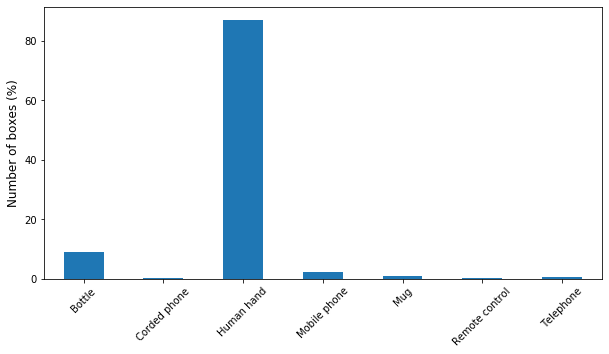

In [9]:
labels = pd.read_csv(LABELS_CSV)
bboxes, urls = get_filtered_bboxes(ANNO_CSV, URLS_CSV, labels)
class_load, factors = get_class_load_and_factors(bboxes)
plot_class_load(class_load)

In [10]:
if not os.path.isfile(LABEL_MAP_PATH):
    create_label_map(LABEL_MAP_PATH, labels)
label_dict = label_map_util.get_label_map_dict(LABEL_MAP_PATH)

In [25]:
total = len(bboxes.ImageID.unique())
with contextlib2.ExitStack() as tf_record_close_stack:
    output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(tf_record_close_stack, 
                                                                             RECORDS_FILEPATH,
                                                                             NUM_SHARDS)

    for counter, image_data in enumerate(bboxes.groupby('ImageID')):
        #tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 1000, counter)
        
        image_id, image_annotations = image_data
        print(f"Processing image {counter+1}/{total} at {image_id}")
        
        url = urls[urls.ImageID == image_id].iloc[0].image_url
        encoded_jpg = get_encoded_image_bytes_from_url(url)

        tf_example = tf_example_from_annotations_data_frame(image_annotations, label_dict, encoded_jpg)
        if tf_example:
            #shard_idx = int(image_id, 16) % FLAGS.num_shards
            factor = factors[factors.ImageID == image_id].iloc[0].Factor
            for i in range(factor):
                shard_idx = (counter + i) % NUM_SHARDS
                output_tfrecords[shard_idx].write(tf_example.SerializeToString())
                
        break

Processing image 1/2330 at 000a1249af2bc5f0


In [24]:

factor = factors[factors.ImageID == "000a1249af2bc5f0"].iloc[0].Factor
factor

1

## Example image from each class

In [ ]:
#url = urls[urls.ImageID.isin(bboxes.ImageID)].sample(n=1).iloc[0].image_url
df = bboxes.groupby('LabelName').apply(pd.DataFrame.sample, n=1).reset_index(drop=True)
df = pd.merge(df, urls, on="ImageID")
for url in df.image_url:
    plt.figure()
    encoded_jpg = get_encoded_image_bytes_from_url(url)
    image = decode_jpg_image(encoded_jpg)
    _= plt.imshow(image)

In [ ]:
bboxes[bboxes.IsGroupOf == 1].groupby("ClassName")["LabelName"].count()